In [1]:
from collections import defaultdict, OrderedDict
from functools import reduce
from itertools import chain, cycle, islice

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML
import smartsheet

from portfolio import (FTECashFlow, CashFlow, combine_flows, debug_row, discount,
                       PortfolioFTEParser, PortfolioSheetRow, debug_row)
from utils import colorscale, get_smartsheet_cell, currency_fmt_to_cols, SmartsheetRow

# Portfolio Cash Flow Analysis

In [2]:
# Define a quartely time schema
years_in_model = 3
periods_in_year = 4
# TODO: rename to "periods_1_12"
quarters = list(range(1, years_in_model * periods_in_year + 1))  # list bc we don't want this to be a generator
# TODO: rename to "periods_0_11"
quarters_index = list(range(years_in_model * periods_in_year))
quarter_labels = ['Q' + str(q) for q in quarters]

# smartsheet
access_token = 'u1zwu2cf2708fdfuy6y46ttwx3'
sheet_id = 3317327430215556
ss = smartsheet.Smartsheet(access_token)
sheet = ss.Sheets.get_sheet(sheet_id)

# COST_BASELINE = get_smartsheet_cell(21, 3, sheet, 'value') / periods_in_year  # ($M/year)
COST_VARIABLE = get_smartsheet_cell(21, 3, sheet, 'value') / periods_in_year  # ($/DGY)
COST_PER_FTE  = get_smartsheet_cell(12, 3, sheet, 'value') / periods_in_year  # ($M/yr)

In [3]:
# Allow for easy targeting of rows, here [20 - 70]
SHEET_ROW_START = 38
SHEET_ROW_END = 95

def sheet_row_to_cf(row):
    if isinstance(row, PortfolioSheetRow):
        return CashFlow(
            delay_qtrs = row.delay_qtrs,
            digital_gallons = row.digital_gallons,
            discount_rate = row.discount_rate,
            max_amt = row.max_amt,
            scale_up_qtrs = row.scale_up_qtrs,
            function = row.function,
            name = row.name,
            is_cost = row.is_cost,
            start_amt=row.start_value,
        )
    else:  # PortfolioFTEParser
        return FTECashFlow(
            discount_rate = row.discount_rate,
            fte_per_period = row.fte_per_period,
            fte_period_cost = COST_PER_FTE,
            fte_y1 = row.fte_y1,
            fte_y2 = row.fte_y2,
            fte_y3 = row.fte_y3,
            name = row.name
        )


def get_parser_for_row(sheet_row):
    """Not all rows are the same. This function will choose the correct parser,
       and show there is not a parser if it is a row that should be skipped"""
    cells = sheet_row.to_dict()['cells']
    include = cells[PortfolioSheetRow.CELL_08.index].get('value', None)
    include = True if include == "Yes" else False
    project_code = cells[PortfolioSheetRow.CELL_09.index].get('value', None)
    function = cells[PortfolioSheetRow.CELL_14.index].get('value', None)
    if not include or project_code is None or function is None:
        return None
    elif function == 'Multi-Step (Yr)':
        return PortfolioFTEParser
    else:
        return PortfolioSheetRow
    
# iterate through smartsheet and build project map, then sort it
project_map = defaultdict(list)
for index, sheet_row in enumerate(sheet.rows):
    if index < SHEET_ROW_START or index > SHEET_ROW_END:
        continue
    Parser = get_parser_for_row(sheet_row)
    if Parser is None:
        continue

    row = Parser(sheet_row.to_dict())
    project_map[row.project_code].append(sheet_row_to_cf(row))

project_map = OrderedDict(sorted(project_map.items()))  # sort ordered dictionary by keys

In [4]:
# Build Cash Flow DataFrame from project_map
rows = []
for project_id, cash_flows in project_map.items():
    for cash_flow in cash_flows:
        rows.append([project_id, True, cash_flow.name] + cash_flow.discounted_qtr)  # Discounted
        rows.append([project_id, False, cash_flow.name] + cash_flow.non_discounted_qtr)  # Undiscounted
        
cf_df = pd.DataFrame(data=rows, columns=['project', 'discounted', 'name'] + quarter_labels)
summarized_df = cf_df.groupby(['project', 'discounted'])\
                  .sum(numeric_only=True)\
                  .sum(numeric_only=True, axis=1)\
                  .reset_index(name='NPV ($)')\
                  .sort_values(by=['project'])

# Create a dataframe with variable cost
rows = []
for project_id, flows in project_map.items():
    unit_multiplier = 10**6  # put in dollars
    dg_to_variable_cost = lambda v: v * unit_multiplier * COST_VARIABLE

    for cf in flows:
        d_dg_cost = list(map(dg_to_variable_cost, cf.discounted_dg_qtr))
        nd_dg_cost = list(map(dg_to_variable_cost, cf.non_discounted_dg_qtr))
        d_variable_cost = [0]  # No variable cost at Q0
        nd_variable_cost = [0]  # No variable cost at Q0
        # iterable is of form [(0, (0, 1)), (1, (1, 2)), (n, (n + 1))]
        for index, step in list(enumerate(zip(quarters_index, quarters)))[:-1]:  
            # integraing using trapezoidal riemann sum
            d_variable_cost.append(np.trapz([d_dg_cost[index], d_dg_cost[index + 1]], step))
            nd_variable_cost.append(np.trapz([nd_dg_cost[index], nd_dg_cost[index + 1]], step))
    
        rows.append([project_id, True, cf.name] + d_variable_cost)
        rows.append([project_id, False, cf.name] + nd_variable_cost)
    
vc_df = pd.DataFrame(data=rows, columns=['project', 'discounted', 'name'] + quarter_labels)
summarized_vc_df = vc_df.groupby(['project', 'discounted'])\
                      .sum(numeric_only=True)\
                      .sum(numeric_only=True, axis=1)\
                      .reset_index(name='Variable Cost ($)')\
                      .sort_values(by=['project'])
# Merge the two together
summarized = pd.merge(summarized_df, summarized_vc_df, how='inner', on=['project', 'discounted'])
summarized = summarized.apply(currency_fmt_to_cols(['NPV ($)', 'Variable Cost ($)']))

summarized_df.apply(currency_fmt_to_cols(['NPV ($)']))

,project,discounted,NPV ($)
0,BP,False,9.43m
1,BP,True,8.16m
2,FS,False,3.75m
3,FS,True,3.37m
4,INT,False,-4.75m
5,INT,True,-4.02m
6,PV,False,3.24m
7,PV,True,2.56m


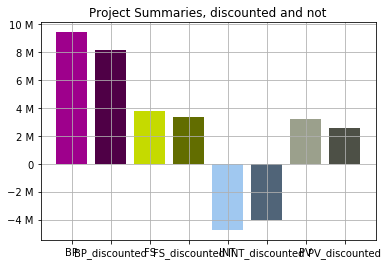

In [5]:
def gen_label(row):
    postfix = '_discounted' if row['discounted'] else ''
    return row['project'] + postfix

table = cf_df.groupby(['project', 'discounted'])\
          .sum(numeric_only=True)\
          .sum(numeric_only=True, axis=1)\
          .reset_index(name='NPV')\
          .sort_values(by=['project'])

table['label'] = table.apply(gen_label, axis=1)
table


# This is way overly complex, but was fun to write
colors = ["#9e008c", "#C5DA00", "#A0C8F0", "#9BA08C"]
colors_cycled = list(islice(
    cycle(colors), # generator of infinitely repeated colors
    0,                 # start at the beginning
    len(project_map)), # we're going to zip later & 2x the proj num is # of bars
) 
darkened_colors = map(lambda color: colorscale(color, .5), colors_cycled)
bar_colors = list(chain.from_iterable(zip(colors_cycled, darkened_colors)))

# TODO: Add colors to bars based on project code beign in the x-axis label
fig = plt.figure()
fig.patch.set_facecolor('#ffffff')
ax = fig.add_subplot(1, 1, 1)
ax.bar(table['label'], table['NPV'], color=bar_colors)
ax.set_title('Project Summaries, discounted and not')
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.grid(True)

In [6]:
def display_dataframe(df, title):
    display(HTML(f'<div><h3>{title}</h3></div>'))
    df.loc["Total"] = df.sum(numeric_only=True)
    df = df.apply(currency_fmt_to_cols(quarter_labels))
    cleaned = df.drop(['project', 'discounted'], axis=1)
    display(cleaned)

    
for project_id in cf_df['project'].unique():
    display(HTML(f'<div><h1>{project_id}</h1><hr /></div>'))
    ndf = cf_df[cf_df['project'] == project_id].set_index('name')
    display_dataframe(ndf[ndf['discounted']].copy(), "Discounted Cash Flows")
    display_dataframe(ndf[ndf['discounted'] == False].copy(), "Undiscounted Cash Flows")

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Batch Internal Headcount,-49.4k,-48.2k,-47k,-45.9k,-89.6k,-87.4k,-85.2k,-83.2k,-122k,-119k,-116k,-113k
Batch External Investment,-100k,-104k,-107k,-110k,-114k,-117k,-120k,-124k,-127k,-130k,-133k,-136k
Revenue Defense - Showme,50k,49.5k,49.1k,48.6k,48.2k,47.7k,47.3k,46.8k,46.4k,46k,45.5k,45.1k
United Ethanol Whitespace Win,30k,29.7k,29.4k,29.2k,28.9k,28.6k,28.4k,28.1k,27.8k,27.6k,27.3k,27.1k
Guardian - Hankinson Defense,0,0,0,0,0,46.3k,45.6k,44.9k,44.2k,43.5k,42.8k,42.2k
Alcorn - Defense / Contract Extension,0,0,0,47.7k,47k,46.3k,45.6k,44.9k,44.2k,43.5k,42.8k,42.2k
Valero - Net new,0,0,0,0,0,0,0,0,0,0,0,31.2k
Madeira - Fleet Trials,0,0,0,0,0,0,0,0,0,21.7k,21.4k,21.1k
Projected BP Offensive,0,0,0,0,117k,229k,425k,726k,1.1m,1.47m,1.74m,1.9m


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Batch Internal Headcount,-49.4k,-49.4k,-49.4k,-49.4k,-98.9k,-98.9k,-98.9k,-98.9k,-148k,-148k,-148k,-148k
Batch External Investment,-100k,-104k,-108k,-112k,-117k,-121k,-125k,-129k,-133k,-138k,-142k,-146k
Revenue Defense - Showme,50k,50k,50k,50k,50k,50k,50k,50k,50k,50k,50k,50k
United Ethanol Whitespace Win,30k,30k,30k,30k,30k,30k,30k,30k,30k,30k,30k,30k
Guardian - Hankinson Defense,0,0,0,0,0,50k,50k,50k,50k,50k,50k,50k
Alcorn - Defense / Contract Extension,0,0,0,50k,50k,50k,50k,50k,50k,50k,50k,50k
Valero - Net new,0,0,0,0,0,0,0,0,0,0,0,50k
Madeira - Fleet Trials,0,0,0,0,0,0,0,0,0,25k,25k,25k
Projected BP Offensive,0,0,0,0,125k,248k,467k,810k,1.25m,1.69m,2.03m,2.25m


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Frontsight Internal Headcount,-49.4k,-48.2k,-47k,-45.9k,-89.6k,-87.4k,-85.2k,-83.2k,-122k,-119k,-116k,-113k
Pipeline FS Product Credits,-45k,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
Pipeline FS - Stockton,0,0,0,0,40.8k,39.8k,38.8k,37.9k,36.9k,36k,35.2k,34.3k
Pipeline FS - Magic Valley,0,0,41.8k,40.3k,38.8k,37.4k,36.1k,34.8k,33.5k,32.3k,31.1k,30k
Projected Offensive Wins,0,0,0,151k,178k,227k,304k,401k,496k,566k,608k,627k
Projected Defensive Wins,0,0,0,0,0,0,18.1k,21.4k,27.3k,36.6k,48.3k,59.7k
Total,-94.4k,-48.2k,-5.24k,145k,168k,217k,312k,412k,472k,553k,606k,638k


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Frontsight Internal Headcount,-49.4k,-49.4k,-49.4k,-49.4k,-98.9k,-98.9k,-98.9k,-98.9k,-148k,-148k,-148k,-148k
Pipeline FS Product Credits,-45k,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
Pipeline FS - Stockton,0,0,0,0,45k,45k,45k,45k,45k,45k,45k,45k
Pipeline FS - Magic Valley,0,0,45k,45k,45k,45k,45k,45k,45k,45k,45k,45k
Projected Offensive Wins,0,0,0,156k,187k,242k,327k,438k,548k,633k,688k,719k
Projected Defensive Wins,0,0,0,0,0,0,19.5k,23.4k,30.2k,40.9k,54.7k,68.4k
Total,-94.4k,-49.4k,-4.43k,152k,178k,233k,338k,452k,519k,616k,685k,729k


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Internal Headcount,-49.4k,-48.2k,-47k,-45.9k,-89.6k,-87.4k,-85.2k,-83.2k,-122k,-119k,-116k,-113k
Internal Headcount,-49.4k,-48.2k,-47k,-45.9k,-89.6k,-87.4k,-85.2k,-83.2k,-122k,-119k,-116k,-113k
Internal Headcount,-49.4k,-48.2k,-47k,-45.9k,-89.6k,-87.4k,-85.2k,-83.2k,-122k,-119k,-116k,-113k
Internal Headcount,-49.4k,-48.2k,-47k,-45.9k,-89.6k,-87.4k,-85.2k,-83.2k,-122k,-119k,-116k,-113k
Total,-198k,-193k,-188k,-184k,-358k,-350k,-341k,-333k,-487k,-475k,-463k,-452k


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Internal Headcount,-49.4k,-49.4k,-49.4k,-49.4k,-98.9k,-98.9k,-98.9k,-98.9k,-148k,-148k,-148k,-148k
Internal Headcount,-49.4k,-49.4k,-49.4k,-49.4k,-98.9k,-98.9k,-98.9k,-98.9k,-148k,-148k,-148k,-148k
Internal Headcount,-49.4k,-49.4k,-49.4k,-49.4k,-98.9k,-98.9k,-98.9k,-98.9k,-148k,-148k,-148k,-148k
Internal Headcount,-49.4k,-49.4k,-49.4k,-49.4k,-98.9k,-98.9k,-98.9k,-98.9k,-148k,-148k,-148k,-148k
Total,-198k,-198k,-198k,-198k,-395k,-395k,-395k,-395k,-593k,-593k,-593k,-593k


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
PV Internal Headcount,-49.4k,-48.2k,-47k,-45.9k,-89.6k,-87.4k,-85.2k,-83.2k,-122k,-119k,-116k,-113k
Benefits - Contracted GPRE,93.8k,92.3k,90.9k,89.5k,88.1k,86.8k,85.4k,84.1k,82.8k,81.5k,80.3k,79.1k
Benefits - Potential GPRE,0,0,0,51.3k,78.7k,119k,175k,247k,334k,426k,513k,583k
Total,44.3k,44.1k,43.8k,94.9k,77.3k,118k,175k,248k,295k,389k,477k,549k


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
PV Internal Headcount,-49.4k,-49.4k,-49.4k,-49.4k,-98.9k,-98.9k,-98.9k,-98.9k,-148k,-148k,-148k,-148k
Benefits - Contracted GPRE,93.8k,93.8k,93.8k,93.8k,93.8k,93.8k,93.8k,93.8k,93.8k,93.8k,93.8k,93.8k
Benefits - Potential GPRE,0,0,0,56.2k,89.1k,139k,210k,307k,427k,562k,698k,818k
Total,44.3k,44.3k,44.3k,101k,84k,133k,205k,302k,373k,508k,643k,764k


In [15]:
class Project():
    """Add cash flows to a project"""
    def __init__(self, name, cash_flows=None):
        self.name = name
        self.cash_flows = cash_flows
        # Generate Graph portion
        self.graph_out = widgets.Output()
        self.update_graphs()
        # Generate Table portion
        self.table_out = widgets.Output()
        self.update_table()
        self.app = widgets.VBox(children=[self.graph_out, self.table_out], layout=widgets.Layout(overflow="hidden"))
        display(self.app)
    
    def to_df(self):
        df = pd.DataFrame(map(lambda cf: cf.to_json(), self.cash_flows)).drop(['flow_id'], axis=1)
        return df.set_index('name')
            
    def update_table(self):
        self.table_out.clear_output(wait=True)
        if len(self.cash_flows) == 0:
            return
        
        table = self.to_df()
        with self.table_out:
            display(table)
        
    def update_graphs(self):
        self.graph_out.clear_output(wait=True)
        if len(self.cash_flows) == 0:
            return

        def trim_axs(axs, N):
            axs = axs.flat
            for ax in axs[N:]:
                ax.remove()
            return axs[:N]
        
        def get_max(flows):
            values = reduce(
                list.__add__,
                [list(map(
                    lambda v: abs(v),
                    flow.non_discounted_qtr + flow.discounted_qtr
                )) for flow in flows])
            maximum = max(values)
            maximum += maximum * .2  # pad value
            return -1 * maximum, maximum
        
        # capture stdout of matplotlib to output catching context graph_out as widget to include
        with self.graph_out:
            cols = 4
            num_cash_flows = len(self.cash_flows)
            rows = 1 if num_cash_flows == 4 else num_cash_flows // cols + 1
            figsize = (12, rows * 3)
            fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
            fig.patch.set_facecolor('#ffffff')
            axs = trim_axs(axs, len(self.cash_flows))
            ymin, ymax = get_max(self.cash_flows)
            for ax, cf in zip(axs, self.cash_flows):
                ax.set_title(cf.name)
                ax.set_ylim([ymin,ymax])
                ax.grid(True)
                ax.yaxis.set_major_formatter(ticker.EngFormatter())
                ax.xaxis.set_ticks(range(1, 13))
                ax.axhline(y=0, color='black', linestyle='--')
                # TODO: should pull from "tot_qtrs" in some way
#                 linestyle_discounted = '-' if cf.discounted else '--'
#                 linestyle_non_discounted = '--' if cf.discounted else '-'
                ax.plot(quarters_index, cf.discounted_qtr, color='r', label='discounted')
                ax.plot(quarters_index, cf.non_discounted_qtr, label='non-discounted')
                ax.legend()
                
            plt.show(fig)

In [16]:
# Build UI from project_map
projects = []
for project_id, cash_flows in project_map.items():
    display(HTML(f'<div><h1>{project_id} - EBITDA</h1><br /><hr /></div>'))
    projects.append(Project(project_id, cash_flows))
    
projects.sort(key=lambda x: x.name)

In [9]:
graph_out = widgets.Output()

def get_x_ticks(index, bar_width, step=1):
    return [x - (bar_width * len(projects)) + (bar_width * index) for x in range(12)]

def plot_projects_summary(cf_attribute):
    projects_values = map(lambda p: combine_flows(p.cash_flows, cf_attribute), projects)
    projects_net = [sum(values) for values in zip(*projects_values)]

    figsize = (25, 8)
    fig, ax = plt.subplots(figsize=figsize)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    fig.patch.set_facecolor('#ffffff')
    plt.xticks(range(0, 12))
    bar_room = .75 # 75% of space will have a bar plotted on it
    bar_width = bar_room * 1 / (len(projects) + 1)  # + 1 in denominator to account for 'net'
    legend_parents = []
    for i, project in enumerate(projects):
        xseries = get_x_ticks(i, bar_width)
        plot = plt.bar(
            xseries,
            combine_flows(project.cash_flows, cf_attribute),
            width=bar_width,
            color=colors[i]
        )
        legend_parents.append(plot)

    legend_parents = [p[0] for p in legend_parents]
    net_xseries = get_x_ticks(len(projects), bar_width)
    net_plot = plt.bar(quarter_labels, projects_net, color='black', width=bar_width)

    legend_parents.append(net_plot[0])
    plt.legend((*legend_parents,), (*map(lambda p: p.name, projects), 'net'), loc='upper left')
    plt.show()
    
def plot_digital_gallons():
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.patch.set_facecolor('#ffffff')
    flows = [quarter_labels]  # first argument are x-labels in stackplots
    for project in projects:
        aggregated_dg_qtr = combine_flows(project.cash_flows, 'non_discounted_dg_qtr')
        flows.append(list(map(lambda x: x * 10**6, aggregated_dg_qtr)))
    plt.stackplot(
        *flows,
        labels=list(map(lambda p: p.name, projects)),
        colors=colors
    )
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    plt.legend(loc='upper left')
    plt.title('Digital Gallon Contribution')
    plt.ylabel('Digital Gallons')
    plt.show()

def plot_program_cost():
    """Currently units plot in "millions". 
    
    multiplier  - 10**0 -> millions
                - 10**3 -> hundred thousands dollars
                - 10**6 -> dollars
    """
    unit_multiplier = 10**6
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.patch.set_facecolor('#ffffff')

    baseline_cost = [discount(COST_BASELINE * unit_multiplier, .1, period_n) for period_n in quarters_index]
    dg_flows = [quarter_labels, baseline_cost]  # first argument are x-labels in stackplots
    project_keys = project_map.keys()

    agg_vc_df = vc_df.groupby(['project', 'discounted']).sum(numeric_only=True).reset_index()
    discounted_agg_vc_df= agg_vc_df[agg_vc_df['discounted']]
    for _, row in discounted_agg_vc_df.iterrows():
        dg_flows.append([getattr(row, label) for label in quarter_labels])
    
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    plt.stackplot(
        *dg_flows,
        labels=['baseline cost'] + list(map(lambda p: p.name + ' variable cost', projects)),
        colors=colors
    )
    plt.legend(loc='upper left')
    plt.title('Discounted Program Cost')
    plt.show()

def graph_projects_cash_flow(_):
    graph_out.clear_output(wait=True)
    
    with graph_out:
#         display(HTML('<h2>Program Cost</h2>'))
#         plot_program_cost()
        
        #  disply(HTML('<h2>Digital Gallons by Project'))
        plot_digital_gallons()
        
        display(HTML('<h2>Discounted Cash Flows</h2>'))
        plot_projects_summary('discounted_qtr')
        
        display(HTML('<h2>Undiscounted Cash Flows</h2>'))
        plot_projects_summary('non_discounted_qtr')

with graph_out:
    graph_projects_cash_flow(None)

# button = widgets.Button(description='Refresh Chart')
# button.on_click(graph_projects_cash_flow)

chart = widgets.VBox(children=[graph_out])
chart

In [10]:
cf_df.sort_values(by=['discounted', 'project'], inplace=True)

In [11]:
import string
alphabet = string.ascii_uppercase
excel_columns_names = list(alphabet)
for letter1 in alphabet:
    for letter2 in alphabet:
        excel_columns_names.append(f'{letter1}{letter2}')

In [12]:
# This entire cell contains all of the code needed
# to build the excel sheet to be downloaded

def record_project(project, sheet, start_row, start_column=0):
    df = project.to_df()
    df = df.fillna(0)
    bold = workbook.add_format({'bold': True})
    row_num = start_row
    # Write the project name
    sheet.write(row_num, start_column, project.name)
    row_num += 1
    # write index then columns
    sheet.write(row_num, start_column, 'index', bold)
    for col_index, col in enumerate(df, 1):  # start at 1 since index was written
        sheet.write(row_num, start_column + col_index, col, bold)
        
    for index, row in df.iterrows():
        row_num += 1
        sheet.write(row_num, start_column, index)
        for col_index, cell_value in enumerate(row, 1):
            sheet.write(row_num, start_column + col_index, cell_value)

writer = pd.ExcelWriter('./demo.xlsx', engine='xlsxwriter')
cf_df.to_excel(writer, sheet_name='output', index=False)

# calculate which cells hold the quarter values
num_quarters = len(quarters)
start_row = 2
end_row = start_row + len(cf_df) - 1
QUARTER_START_COLUMN = 3  # After 'project', 'discouted', and 'name'
start_quarter_columns = excel_columns_names[QUARTER_START_COLUMN]
end_quarter_columns = excel_columns_names[QUARTER_START_COLUMN + num_quarters]
quarter_cells = f'{start_quarter_columns}{start_row}:{end_quarter_columns}{end_row}'

# grab objects from pandas object
workbook  = writer.book
output_worksheet = writer.sheets['output']
projects_worksheet = workbook.add_worksheet('projects')

start_row = 0
for project in projects:
    record_project(project, projects_worksheet, start_row)
    start_row += len(project.cash_flows) + 3  # 3 for project name, header row, and a space

# create and apply formatting
float_format = workbook.add_format({'num_format': '##0.0000'})
## output sheet
output_worksheet.set_column(quarter_cells, None, float_format)
output_worksheet.set_column('C:C', 30)
output_worksheet.conditional_format(quarter_cells, {'type': '3_color_scale'})
## project sheet
projects_worksheet.set_column('A:A', 30)
projects_worksheet.set_column('B:H', 15)

writer.save()

In [13]:
# %%html
# <style>
# .dwnld {
#     border: 1px solid black;
#     border-radius: 4px;
#     padding: 5px;
#     text-decoration: none !important;
# }
# </style>
# <a class="dwnld" href="./voila/static/demo.xlsx" download="demo.xlsx">Download Excel Sheet</a>

In [14]:
# Play instances
# cf = CashFlow(
#     delay_qtrs=4, digital_gallons=100, discount_rate=.1, function='sigmoid',
#     is_cost=False, start_amt=1, max_amt=5, scale_up_qtrs=4, tot_qtrs=12, name='test'
# )
# cf.quick_view(discounted=False)